In [ ]:
import torch 
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader


In [ ]:
num_samples = 1000
latent_dim = 10
num_epochs = 200
batch_size = 32
lr = 1e-3
lambda_gp = 10


In [ ]:
class SyntheticDataset(Dataset):

  def __init__(self, transform=None):

    self.x = x
    self.n_samples = x.shape[0]
    self.transform = transform

  def __getitem__(self, index):

    # e.g. dataset[0]
    sample = self.x[index]
    # apply transformation, if present
    if self.transform:

      sample = self.transform(sample)

    return sample
    
  def __len__(self):

    # len(dataset)

    return self.n_samples

In [ ]:

angles = [k*45 for k in range(9)]
x = torch.tensor([]).view(-1,2)
for angle in angles:
  mean = torch.tensor([np.sin(angle/180*np.pi), np.cos(angle/180*np.pi)]).view(-1,2)
  x = torch.cat([x, torch.randn(num_samples, 2)*0.1 + mean])

In [ ]:
dataset = SyntheticDataset()
train_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

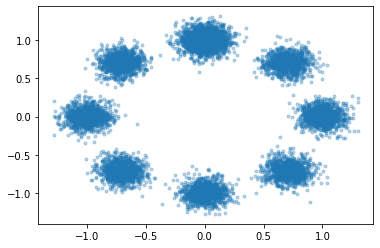

In [ ]:
plt.plot(x[:,0], x[:,1], '.', alpha=0.3)

In [ ]:
generator = nn.Sequential(
    nn.Linear(latent_dim,50),
    nn.LeakyReLU(),
    nn.Linear(50,50),
    nn.LeakyReLU(),
    nn.Linear(50,50),
    nn.LeakyReLU(),
    nn.Linear(50,2)
)
discriminator = nn.Sequential(
    nn.Linear(2,50),
    nn.LeakyReLU(),
    nn.Linear(50,50),
    nn.LeakyReLU(),
    nn.Linear(50,50),
    nn.LeakyReLU(),
    nn.Linear(50,1)
)


In [ ]:
optim_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
optim_g = torch.optim.RMSprop(generator.parameters(), lr = lr) 
dataset = SyntheticDataset()
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [ ]:
def compute_gp(x_real, x_gen):

  alpha = np.random.random()  # random number in [0,1]
  interpolate = alpha * x_real + (1 - alpha) * x_gen  # interpolation between real and generated data
  interpolate.requires_grad_(True)
  d_inter = discriminator(interpolate)  # discriminator's output on interpolation
  grad_outputs = torch.tensor(np.ones((x_real.size(0), 1)), requires_grad=False).float()
  gradients = torch.autograd.grad(
      outputs=d_inter,
      inputs=interpolate,
      grad_outputs=grad_outputs,
      create_graph=True,
      retain_graph=True,
      only_inputs=True,
  )[0]  # computation of gradients
  gradients = gradients.view(gradients.size(0), -1)
  gradients_penalty = (
          ((gradients + 1e-6).norm(2, dim=1) - 1) ** 2).mean()  # add small epsilon term for stability
  return gradients_penalty

In [ ]:
def train(loader, loss='lsgan'):
  history = defaultdict(list)
  z_test = torch.randn(3000, latent_dim)

  for epoch in range(num_epochs):
    for i, x_batch in enumerate(loader):

      x_batch = x_batch.float()
      z = torch.randn(x_batch.size(0), latent_dim, dtype=torch.float32)
      x_gen = generator(z)
      d_real = discriminator(x_batch)
      d_fake = discriminator(x_gen.detach())

      if loss == 'lsgan':
        optim_d.zero_grad()
        d_loss = 0.5*(torch.mean((d_real-1)**2) + torch.mean(d_fake**2))
        d_loss.backward()
        optim_d.step()

        d_fake = discriminator(x_gen)
        optim_g.zero_grad()
        g_loss = 0.5*torch.mean((d_fake -1)**2)
        g_loss.backward()
        optim_g.step()

      elif loss == 'wgan':
        #gp = compute_gp(x_batch, x_gen.detach())
        optim_d.zero_grad()
        d_loss = torch.mean(d_fake) - torch.mean(d_real) 
                
        for p in discriminator.parameters():
          p.data.clamp_(-0.01, 0.01)
        d_loss.backward()
        optim_d.step()

        d_fake = discriminator(x_gen)
        optim_g.zero_grad()
        g_loss = - torch.mean(d_fake)
        g_loss.backward()
        optim_g.step()

      elif loss == 'wgangp':
        gp = compute_gp(x_batch, x_gen.detach())
        optim_d.zero_grad()
        d_loss = torch.mean(d_fake) - torch.mean(d_real) \
                  + lambda_gp*gp
        d_loss.backward()
        optim_d.step()

        d_fake = discriminator(x_gen)
        optim_g.zero_grad()
        g_loss = - torch.mean(d_fake)
        g_loss.backward()
        optim_g.step()


    with torch.no_grad():
      x_test = generator(z_test)

      clear_output()
      plt.plot(x[:,0], x[:,1], '.', alpha=0.3, label='real')
      plt.plot(x_test[:,0], x_test[:,1], '.', alpha=0.3, label='fake')
      plt.legend()
      plt.show()






In [ ]:
z_test = torch.randn(1000,latent_dim)
generator(z_test).shape

torch.Size([1000, 2])

In [ ]:

train(train_loader, loss='wgan')

NameError: ignored

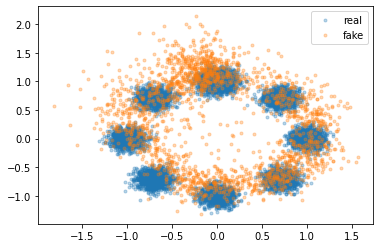

In [ ]:
z_test = torch.randn(2000,10)
with torch.no_grad():
      x_test = generator(z_test)

      clear_output()
      plt.plot(x[:,0], x[:,1], '.', alpha=0.3, label='real')
      plt.plot(x_test[:,0], x_test[:,1], '.', alpha=0.3, label='fake')
      plt.legend()
      plt.show()